In [1]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
import urllib.request
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
from scipy.signal import argrelextrema

import sys
import glob
sys.path.append('/home/pxv220016/prasoon/data/SAMI3-GITM-python')
from utility_programs import filters
from utility_programs.read_routines import SAMI, GITM
import SAMI3_ESMF_Regrid

import h5py
import dask
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
import h5netcdf
import flox
import importlib as il 
import ecef_geodetic


In [2]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace = []


# Adding the local time
ecef_geodetic = il.reload(ecef_geodetic)


for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
print(data)


100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.30s/it]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'GPS_Position', 'LEO_Position', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error']

<xarray.Dataset> Size: 11MB
Dimensions:            (step: 56708)
Dimensions without coordinates: step
Data variables: (12/26)
    Timestamp          (step) float64 454kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 454kB -60.57 -60.57 -60.57 ... 26.16 26.16
    Longitude          (step) float64 454kB -175.0 -175.0 -175.0 ... 2.732 2.732
    Radius             (step) float64 454kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 454kB -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 454kB -1.475e+07 1.345e+07 ... -7.897e+06
    ...                 ...
    Relative_STEC      (step) float64 454kB 86.47 56.26 80.43 ... 52.91 37.42
    Relative_S

### Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).
- `grace` is having the raw data for different dates, `grace_data` is having filtered data (only elevation angle >= 50 is present)

In [57]:
d17 = grace[1]

latitude = list(d17.Latitude.values)

a = 0
b = 1000

c = 1000
d = 2000

maxi_lat = []
mini_lat = []

i = 0
c = 1

orbits = []
orbit_num = []
min_last = 0

while(i+3600 < len(latitude)):
    m = max(latitude[i: i +3600])
    mi = min(latitude[i: i +3600])
    
    if min_last != 0:
        orbits.append([min_last, latitude.index(m)])
        
    orbits.append([latitude.index(m), latitude.index(mi)])
    min_last = latitude.index(mi)
    i += 3600
    orbit_num.append(c)
    orbit_num.append(c)
    c += 1

print(orbits)
print(orbit_num)




[[0, 1738], [1738, 3694], [3694, 5399], [5399, 7224], [7224, 8962], [8962, 10883], [10883, 12666], [12666, 14495], [14495, 16329], [16329, 18110], [18110, 20127], [20127, 21888], [21888, 23755], [23755, 25540], [25540, 27270], [27270, 29070], [29070, 30796], [30796, 32829], [32829, 34370], [34370, 36294], [36294, 38046], [38046, 39935], [39935, 41535], [41535, 46706], [46706, 45128], [45128, 50131], [50131, 48471], [48471, 53418], [53418, 51863]]
[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]


In [62]:
#orbits = [[3200, 5280], [5280, 6880],[6880, 8810], [8810, 10480], [10480, 12280], [12280, 14080], [14080,15780], [15780, 17780]]
nature = ['descending','ascending']*(c-1) # 0 means ascending and 1 means descending
#orbit_num = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]

c_n = []
for i in range(32):
    c_n.append('gps_' + str(i+1) + '_X')
    c_n.append('gps_' + str(i+1) + '_Y')
    c_n.append('gps_' + str(i+1) + '_Z')
    c_n.append('gps_' + str(i+1) + '_stec')
    c_n.append('gps_' + str(i+1) + '_elev')
    c_n.append('gps_' + str(i+1) + '_interp_stec')

c_name = ['orbit', 'nature', 'time', 'grace_X', 'grace_Y', 'grace_Z'] + c_n
print(len(c_name))

date_t = np.unique(d17.date[orbits[0][0]:orbits[-1][1]].values)
t = len(date_t)
print(t)

print(np.unique(d17.PRN))
data_n = np.zeros((t+1, len(c_name)))
data_n = data_n.tolist()

for i in range(len(c_name)):
    data_n[0][i] = c_name[i]


for a, b, c in tqdm(zip(orbits, nature, orbit_num)):
    a1 , a2 = a
    
    subset = d17.sel(step=slice(a1, a2+1))
    d_n = list(subset.groupby('date'))
    
    for time, d in d_n:
        for tt in range(t):
            if time == date_t[tt]:
                
                for i in range(len(d.PRN.values)):
                    pc = (d.PRN.values[i])*6
                    
                    data_n[tt+1][pc] = d.GPS_Position_X.values[i]
                    data_n[tt+1][pc+1] = d.GPS_Position_Y.values[i]
                    data_n[tt+1][pc+2] = d.GPS_Position_Z.values[i]
                    data_n[tt+1][pc+3] = d.Absolute_STEC.values[i]
                    data_n[tt+1][pc+4] = d.Elevation_Angle.values[i]
                    #data_n[tt+1][pc+5] = sami_calculated_stec
                    
                    if data_n[tt+1][3] == 0:
                        data_n[tt+1][0] = c
                        data_n[tt+1][1] = b
                        data_n[tt+1][2] = time
                        data_n[tt+1][3] = d.LEO_Position_X.values[i]
                        data_n[tt+1][4] = d.LEO_Position_Y.values[i]
                        data_n[tt+1][5] = d.LEO_Position_Z.values[i]
                    
                break


print('done')



198
8128
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26
 28 29 30 31 32]


22it [00:44,  2.04s/it]

done


In [63]:
import csv
filename = 'output.csv'

# Write the data to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data_n)

print(f"CSV file '{filename}' has been created.")

CSV file 'output.csv' has been created.


# Line of Sight TEC (LOSTEC)

In [179]:
ecef_geodetic = il.reload(ecef_geodetic)
edens = []
lat_r = []
lon_r = []
alt_r = []
time_r = []
sep_r = []
index = []

prn = 2
col = 2*6

for i in range(50,186):
#for i in range(len(date_t)+1):
    if i != 0 and data_n[i][col] != 0:
        #print(i, data_n[i][col])
        
        t_i = data_n[i][2]
        l_x = data_n[i][3]
        l_y = data_n[i][4]
        l_z = data_n[i][5]
        g_x = data_n[i][col+0]
        g_y = data_n[i][col+1]
        g_z = data_n[i][col+2]
        
        #print(data_n[i][col+3], 'STEC value')
        del_x = g_x - l_x
        del_y = g_y - l_y
        del_z = g_z - l_z
        sp = np.sqrt(del_x**2 + del_y**2 + del_z**2)

        N = 1000
        '''
        x_seq = np.geomspace(l_x,g_x,N)
        y_seq = np.geomspace(l_y,g_y,N)
        z_seq = np.geomspace(l_z,g_z,N)

        for x,y,z in zip(x_seq, y_seq, z_seq):
            lat_n, lon_n, alt_n = ecef_geodetic.ecef_to_lla(x, y, z)
            
            lat_r.append(lat_n)
            lon_r.append(lon_n)
            alt_r.append(alt_n/1000)
            time_r.append(t_i)
            index.append(i)
            sep_r.append(sp)
        '''
        
        num = np.geomspace(1e-3, 1, N)
        
        
        for n in num:
            x = l_x + n*del_x
            y = l_y + n*del_y
            z = l_z + n*del_z
            
            lat_n, lon_n, alt_n = ecef_geodetic.ecef_to_lla(x, y, z)
            
            lat_r.append(lat_n)
            lon_r.append(lon_n)
            alt_r.append(alt_n/1000)
            time_r.append(t_i)
            index.append(i)
            sep_r.append(sp)



print('GRACE lat lon alt', lat_r[0], lon_r[0], alt_r[0])
print('GPS lat lon alt', lat_r[-1], lon_r[-1], alt_r[-1])

        

GRACE lat lon alt 57.669373726409965 -179.46529393999245 454.226927455523
GPS lat lon alt 17.204854696668217 145.98988256466762 19973.62413684649


In [180]:
# Name the csv file (no need to create a file beforehand)
output_file = 'ray-coords.csv'

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['lat', 'lon', 'alt'])  # Write header row
    writer.writerows(zip(lat_r, lon_r, alt_r)) # Enter the list

print('CSV file created')

CSV file created


In [181]:
os.system("time python /home/pxv220016/prasoon/data/SAMI3-GITM-python/SAMI3_ESMF_Regrid.py /home/pxv220016/scratch/2013-03-17_SAMI '20130316' --cols edens --out_dir /home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316 --custom_input_file /home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/ray-coords.csv --ESMF_DIR /home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0/apps/appsO/Linux.gfortran.64.openmpi.default/ --remake_files")

Generating interior points from SAMI outputs:  99%|█████████▊| 1454080/1474560 [00:31<00:00, 46349.89it/s]


Made custom mesh file
Found ESMF weight file, making it again...
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/pxv220016/scratch/2013-03-17_SAMI/src_ugrid.nc
   Destination File: /home/pxv220016/scratch/2013-03-17_SAMI/dst_ugrid.nc
   Weight File: /home/pxv220016/scratch/2013-03-17_SAMI/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.




Variable "time" not present in input file.
Output file will not contain satell

Writing edens 	 vars:(0/1)               : 100%|██████████| 596/596 [03:55<00:00,  2.53it/s]

real	6m11.322s
user	4m20.882s
sys	1m47.550s


0

# Interpolation

In [184]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316/edens_SAMI-REGRID.nc'
#sami = pd.read_csv(path, delimiter='\t')

'''
with open(path, 'rb') as file:
    sami = file.read()
    print(type(sami))
    for lines in sami:
        pass

print('done')
'''
sami = xr.open_dataset(path)
print(sami)

<xarray.Dataset> Size: 652MB
Dimensions:    (sat_step: 136000, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    lat        (sat_step) float64 1MB ...
    lon        (sat_step) float64 1MB ...
    alt        (sat_step) float64 1MB ...
    edens      (sami_time, sat_step) float64 648MB ...


2013-03-17T00:08:10.000000000
[57.66937373 57.66879987 57.66822202 57.66764016 57.66705426 57.66646429
 57.66587022 57.66527203 57.66466968 57.66406315] [-179.46529394 -179.46683649 -179.46838965 -179.4699535  -179.47152811
 -179.47311354 -179.47470988 -179.4763172  -179.47793558 -179.47956508] [454.22692746 454.31814785 454.41000331 454.50249828 454.59563723
 454.68942465 454.78386508 454.87896307 454.97472322 455.07115016]


  0%|                                                | 0/136000 [00:00<?, ?it/s]

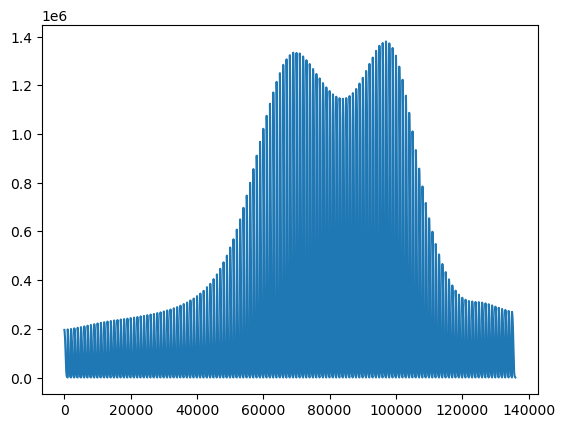

  0%|                                                | 0/136000 [00:00<?, ?it/s]


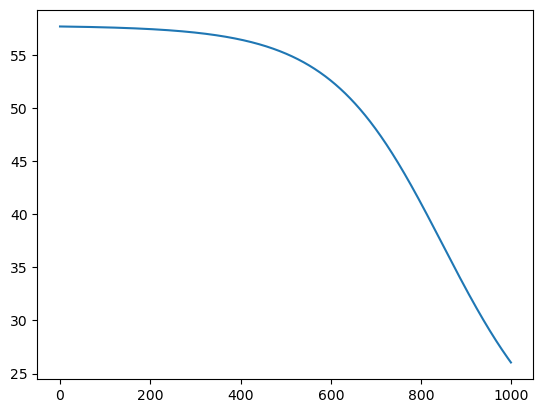

In [191]:
print(time_r[0])
#print(sami.sami_time.dt.time.values)

#print(sami.alt.values)
#print(sami.sami_time.dt.day.values)
print(sami.lat[:10].values, sami.lon[:10].values, sami.alt[:10].values)

eden = []
for i in tqdm(range(len(time_r))):
    e = sami.edens.sel(sami_time=time_r[i], method='nearest')
    plt.plot(e)
    plt.show()

    plt.plot(sami.lat[:1000].values)
    break
    
    eden.append(e[i].values)
    
    if i < len(time_r) -1 and index[i] != index[i+1]:
        tec = sum(eden[:-1])


        num = np.geomspace(1e-3, sep_r[i], len(eden))
        
        stec = 0
        for j in range(len(num)-1):
            s = num[j+1] - num[j]
            stec += s*(eden[j] + eden[j+1])*0.5*1e6

                
        stec = stec/1e16
        
        #stec = tec*sep_r[i]/((N-1)*1e16)*1e6
        print(stec)
        data_n[index[i]][col+5] = stec
        eden = []


    
#print(e.values)


Text(0.5, 0, 'Time')

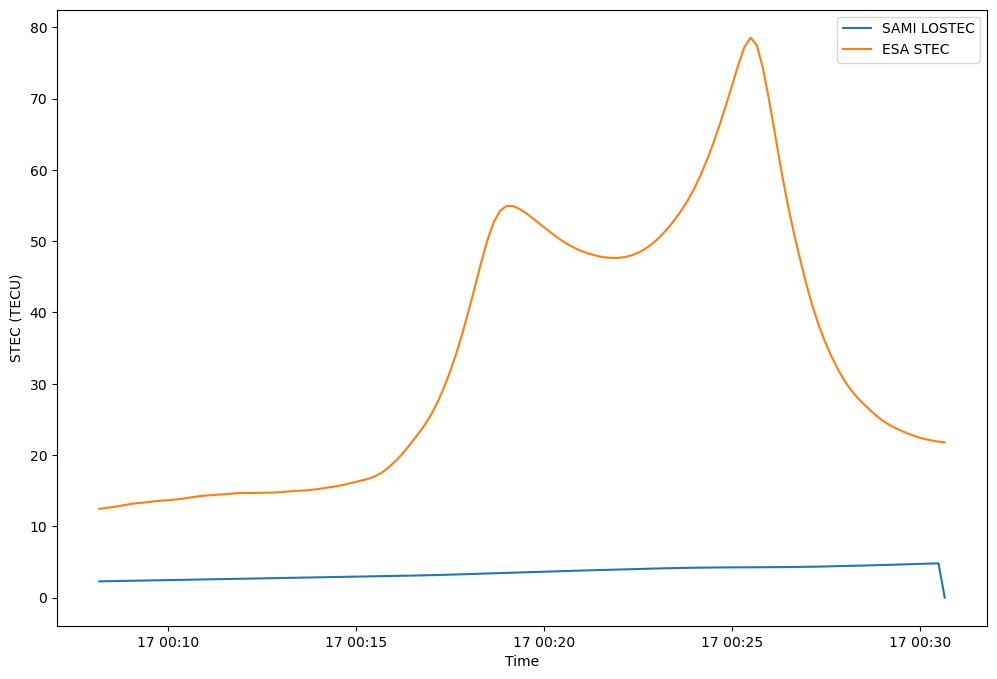

In [176]:
time_stec = []
stec_sami = []
stec_esa = []

for i in range(50, 186):
    time_stec.append(data_n[i][2])
    stec_sami.append(data_n[i][col+5])
    stec_esa.append(data_n[i][col+3])

#print(time_stec)
#print(stec_sami)

plt.figure(figsize=(12,8))
plt.plot(time_stec, stec_sami, label='SAMI LOSTEC')
plt.plot(time_stec, stec_esa, label='ESA STEC')
plt.legend()
plt.ylabel('STEC (TECU)')
plt.xlabel('Time')

In [110]:
sep = 23205596.82373721
l = len(e)
print(l)

print(sum(e.values)*sep)

tec = sum(e.values[:-1])*sep/((l-1)*1e16)
print(tec)

10000
1501242683919327.5
1.5013885507410396e-05
